In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision
from matplotlib import pyplot as plt
import angular_spectrum_tensor_v1 as AST
import cv2
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import mydata
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torchvision import datasets,transforms

d:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
""" Hyper parameters """

# training parameters
Device=torch.device('cuda' if torch.cuda.is_available() else'cpu')
batch_size = 64
learning_rate=3e-3
epochs=30

# physical parameters

lambda_0=532e-3


def Microscope_equiv(res,F,Lmeasure,lambda_0=0.532):
    """transform a microscope system into a single lens"""
    din=Lmeasure/(1+F)# euqvalient din by measurement
    dout=din*F
    D_equal=(1.22*lambda_0/res)*din #the equavalient D
    f_equal=1/(1/din+1/dout)
    return D_equal,f_equal

res=5 #system resolution
lamda_0=0.532
FF=1
Lmeasure=500e3

[D1,f1]=Microscope_equiv(res,FF,Lmeasure)
res=8 #system resolution
lamda_0=0.532
#F=1
FF=1

Lmeasure=400e3
[D2,f2]=Microscope_equiv(res,FF,Lmeasure)



mask1=AST.create_unit_mask_2D(3*32,4*2*30)
mask2=AST.create_unit_mask_2D(3*32,4*2*30)

Bool_mask1=AST.create_Binary_mask_2D(3*32,4*2*30)
Bool_mask2=AST.create_Binary_mask_2D(3*32,4*2*30)

In [3]:
name='xoyr+dark_new'

### change the injection level by tuning the magnitude of NL_ys(2) or NL_xs(2)

In [4]:
from torchvision.transforms import functional as F_vision

In [5]:
""" forward,layer 1 """
angle = 0
shift_y = 0
scale = 1
def f_wn_1(x,theta):
        """  weight transformation """
        w1_temp = AST.MiddlePicture_single_tensor(theta,mask1)
        w1_temp = (F_vision.affine(w1_temp, angle=angle, translate=(0,shift_y), scale=scale, shear=0.0))        
        w1_temp=AST.MiddlePicture2Vector(w1_temp).to(Device)
        x = torch.matmul(x,w1_temp).to(Device)
        return x
""" forward,layer 2"""
def f_wn_2(x,theta):
        """  weight transformation """
        w2_temp=AST.BigPicture_single_tensor_2D(theta,mask2,RawNumber=3,ColumnNumber=4,paddcol=30,paddraw=32,dim_in=12,num_out=10)
        w2_temp = (F_vision.affine(w2_temp.unsqueeze(0), angle=0, translate=(0,0), scale=scale, shear=0.0))        
        w2_temp=AST.BigPicture2Vector_2D(w2_temp,RawNumber=3,ColumnNumber=4,paddcol=30,paddraw=32,dim_in=12,num_out=10).to(Device)
        w2_temp = w2_temp.squeeze(0)
        x=torch.matmul(x,w2_temp).to(Device)
        return x

In [6]:
""" data loading """
transform0 = transforms.Compose(
    [torchvision.transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])



trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform0)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

In [7]:
"""Define NN class"""
class InCoFCNet_test(nn.Module):
    def __init__(self):
        super(InCoFCNet_test, self).__init__()
        self.fc1 = nn.Linear(784, 144)
        self.fc2 = nn.Linear(144, 10)

    def forward(self, x):
        x = f_wn_1(x,self.fc1.weight.t())+self.fc1.bias
        x = F.sigmoid(x)
        x = f_wn_2(x,self.fc2.weight.t())+self.fc2.bias
        return x
    
    def apply_constraints(self):
        self.fc1.weight.data = torch.clamp(self.fc1.weight.data,-1,1)        
        self.fc2.weight.data = torch.clamp(self.fc2.weight.data,-1,1)

In [8]:
net_test=InCoFCNet_test().to(Device)
PATH = 'Training Results/sat-angle shift scale.pth'
net_test.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Sweep angle

In [9]:
angle = 0
shift_y = 0
scale = 1

In [10]:
sweep_angle = np.linspace(0,2,3)

In [11]:
n_pred = []
nl = []
for i in range(3):
    angle = sweep_angle[i]

    y_pred = []
    t_pred = []
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(Device), data[1].to(Device)
        inputs = inputs.view(-1, 784)
        # calculate outputs by running images through the network
        outputs = net_test(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y = predicted.view(-1).cpu().detach().numpy()
        t = labels.view(-1).cpu().detach().numpy()
        for i in range(len(predicted)):
            y_pred.append(y[i])
            t_pred.append(t[i])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    n_pred.append(acc)
    nl.append(angle)
    print(f'Angle: {angle}')
    print(f'Accuracy: {acc}')
angle = 0

Angle: 0.0
Accuracy: 97.49
Angle: 1.0
Accuracy: 96.32
Angle: 2.0
Accuracy: 92.16


In [12]:
net_test_sam=InCoFCNet_test().to(Device)
PATH = 'Training Results/sat-angle.pth'
net_test_sam.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
n_pred_sam = []
nl_sam = []
net_test_sam.to(Device)
for i in range(3):
    angle = sweep_angle[i]

    y_pred = []
    t_pred = []
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(Device), data[1].to(Device)
        inputs = inputs.view(-1, 784)
        # calculate outputs by running images through the network
        outputs = net_test_sam(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y = predicted.view(-1).cpu().detach().numpy()
        t = labels.view(-1).cpu().detach().numpy()
        for i in range(len(predicted)):
            y_pred.append(y[i])
            t_pred.append(t[i])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    n_pred_sam.append(acc)
    nl_sam.append(angle)
    print(f'Angle: {angle}')
    print(f'Accuracy: {acc}')
angle = 0

Angle: 0.0
Accuracy: 97.05
Angle: 1.0
Accuracy: 96.71
Angle: 2.0
Accuracy: 91.78


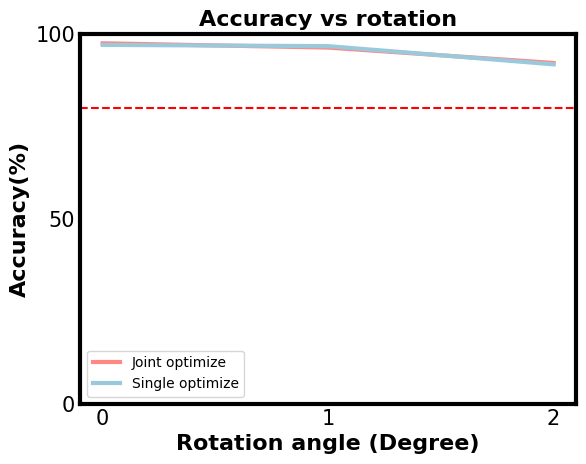

In [14]:
### single parameter
fig, ax = plt.subplots()

plt.plot(nl, n_pred, linewidth=3, color='#FF8884')
plt.plot(nl_sam, n_pred_sam, linewidth=3, color='#9AC9DB')

plt.xlabel('Rotation angle (Degree)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Accuracy(%)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.title('Accuracy vs rotation', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.axhline(y=80, color='r', linestyle='--')
plt.rcParams["figure.figsize"] = (6, 4)
plt.legend(['Joint optimize','Single optimize'], ncol=1)
for spine in ax.spines.values():
    spine.set_linewidth(3)

plt.xticks(np.arange(np.min(nl), np.max(nl)+0.2, 1))
plt.yticks([0,50,100])
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='both', labelsize=15)

#### Sweep shift

In [15]:
sweep_shift = np.linspace(0,2,3)

In [16]:
n_pred = []
nl = []
for i in range(3):
    shift_y = sweep_shift[i]

    y_pred = []
    t_pred = []
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(Device), data[1].to(Device)
        inputs = inputs.view(-1, 784)
        # calculate outputs by running images through the network
        outputs = net_test(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y = predicted.view(-1).cpu().detach().numpy()
        t = labels.view(-1).cpu().detach().numpy()
        for i in range(len(predicted)):
            y_pred.append(y[i])
            t_pred.append(t[i])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    n_pred.append(acc)
    nl.append(shift_y)
    print(f'shift: {shift_y}')
    print(f'Accuracy: {acc}')
shift_y = 0

shift: 0.0
Accuracy: 97.49
shift: 1.0
Accuracy: 96.57
shift: 2.0
Accuracy: 90.13


In [17]:
net_test_sam=InCoFCNet_test().to(Device)
PATH = 'Training Results/sat-shift.pth'
net_test_sam.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
n_pred_sam = []
nl_sam = []
net_test_sam.to(Device)
for i in range(3):
    shift_y = sweep_shift[i]

    y_pred = []
    t_pred = []
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(Device), data[1].to(Device)
        inputs = inputs.view(-1, 784)
        # calculate outputs by running images through the network
        outputs = net_test_sam(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y = predicted.view(-1).cpu().detach().numpy()
        t = labels.view(-1).cpu().detach().numpy()
        for i in range(len(predicted)):
            y_pred.append(y[i])
            t_pred.append(t[i])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    n_pred_sam.append(acc)
    nl_sam.append(shift_y)
    print(f'shift: {shift_y}')
    print(f'Accuracy: {acc}')
shift_y = 0

shift: 0.0
Accuracy: 97.83
shift: 1.0
Accuracy: 97.58
shift: 2.0
Accuracy: 93.27


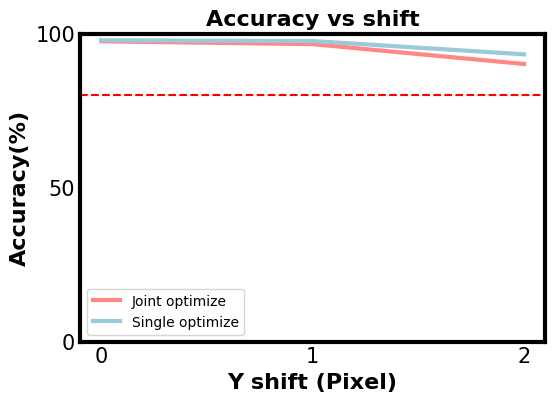

In [20]:
### single parameter
fig, ax = plt.subplots()

plt.plot(nl, n_pred, linewidth=3, color='#FF8884')
plt.plot(nl_sam, n_pred_sam, linewidth=3, color='#9AC9DB')
# plt.plot(nl_sam, n_pred_sam, linewidth=3, color='#D77076')

plt.xlabel('Y shift (Pixel)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Accuracy(%)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.title('Accuracy vs shift', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.axhline(y=80, color='r', linestyle='--')
plt.rcParams["figure.figsize"] = (6, 4)
plt.legend(['Joint optimize','Single optimize'], ncol=1)
for spine in ax.spines.values():
    spine.set_linewidth(3)

plt.xticks(np.arange(np.min(nl), np.max(nl)+0.2, 1))
plt.yticks([0,50,100])
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='both', labelsize=15)

#### Sweep scale

In [21]:
sweep_scale = np.linspace(1,1.1,3)

In [22]:
n_pred = []
nl = []
for i in range(3):
    scale = sweep_scale[i]

    y_pred = []
    t_pred = []
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(Device), data[1].to(Device)
        inputs = inputs.view(-1, 784)
        # calculate outputs by running images through the network
        outputs = net_test(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y = predicted.view(-1).cpu().detach().numpy()
        t = labels.view(-1).cpu().detach().numpy()
        for i in range(len(predicted)):
            y_pred.append(y[i])
            t_pred.append(t[i])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    n_pred.append(acc)
    nl.append(scale)
    print(f'scale: {scale}')
    print(f'Accuracy: {acc}')
scale = 0

scale: 1.0
Accuracy: 97.49
scale: 1.05
Accuracy: 94.91
scale: 1.1
Accuracy: 91.62


In [23]:
net_test_sam=InCoFCNet_test().to(Device)
PATH = 'Training Results/sat-scale.pth'
net_test_sam.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [24]:
n_pred_sam = []
nl_sam = []
net_test_sam.to(Device)
for i in range(3):
    scale = sweep_scale[i]

    y_pred = []
    t_pred = []
    correct = 0
    total = 0
    for data in testloader:
        inputs, labels = data[0].to(Device), data[1].to(Device)
        inputs = inputs.view(-1, 784)
        # calculate outputs by running images through the network
        outputs = net_test_sam(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y = predicted.view(-1).cpu().detach().numpy()
        t = labels.view(-1).cpu().detach().numpy()
        for i in range(len(predicted)):
            y_pred.append(y[i])
            t_pred.append(t[i])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    acc = 100 * correct / total
    n_pred_sam.append(acc)
    nl_sam.append(scale)
    print(f'shift: {scale}')
    print(f'Accuracy: {acc}')
scale = 0

shift: 1.0
Accuracy: 96.93
shift: 1.05
Accuracy: 95.95
shift: 1.1
Accuracy: 91.98


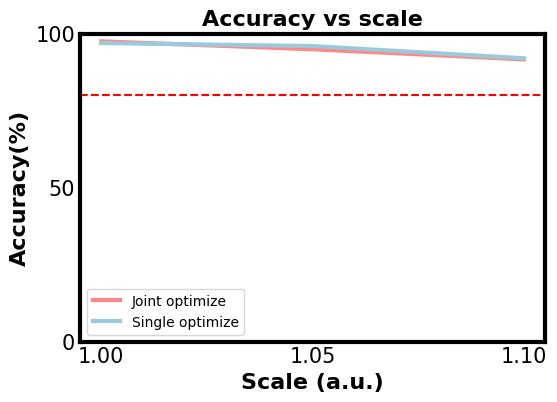

In [25]:
fig, ax = plt.subplots()

plt.plot(nl, n_pred, linewidth=3, color='#FF8884')
plt.plot(nl_sam, n_pred_sam, linewidth=3, color='#9AC9DB')
# plt.plot(nl_sam, n_pred_sam, linewidth=3, color='#D77076')

plt.xlabel('Scale (a.u.)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.ylabel('Accuracy(%)', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.title('Accuracy vs scale', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.axhline(y=80, color='r', linestyle='--')
plt.rcParams["figure.figsize"] = (6, 4)
plt.legend(['Joint optimize','Single optimize'], ncol=1)
for spine in ax.spines.values():
    spine.set_linewidth(3)

plt.xticks(np.arange(np.min(nl), np.max(nl)+0.01, 0.05))
plt.yticks([0,50,100])
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='both', labelsize=15)

### 2D sweep

In [26]:
net_test=InCoFCNet_test().to(Device)
PATH = 'Training Results/standard_bp.pth'
net_test.load_state_dict(torch.load(PATH))
net_test_sam=InCoFCNet_test().to(Device)
PATH = 'Training Results/sat-angle shift.pth'
net_test_sam.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [27]:
angle = 0
shift_y = 0
scale = 1

In [40]:
# sweep_angle = np.linspace(0,1.0,3)
# sweep_scale = np.linspace(1,1.05,3)

# acc_grid_net = np.zeros((len(sweep_angle), len(sweep_scale)))
# acc_grid_net_sam = np.zeros((len(sweep_angle), len(sweep_scale)))

# for i, angle in enumerate(sweep_angle):
#     for j, scale in enumerate(sweep_scale):

#         correct = 0
#         total = 0
#         for data in testloader:
#             inputs, labels = data[0].to(Device), data[1].to(Device)
#             inputs = inputs.view(-1, 784)

#             outputs = net_test(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)
#         acc_grid_net[i, j] = 100 * correct / total
#         print(f'net_test -> Angle: {angle:.2f}, Scale: {scale:.2f}, Accuracy: {acc_grid_net[i,j]:.2f}%')

#         correct = 0
#         total = 0
#         for data in testloader:
#             inputs, labels = data[0].to(Device), data[1].to(Device)
#             inputs = inputs.view(-1, 784)

#             outputs = net_test_sam(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)
#         acc_grid_net_sam[i, j] = 100 * correct / total
#         print(f'net_test_sam -> Angle: {angle:.2f}, Scale: {scale:.2f}, Accuracy: {acc_grid_net_sam[i,j]:.2f}%')


In [48]:
sweep_angle = np.linspace(0,3.0,21)
sweep_shift = np.linspace(0,3.0,21)

acc_grid_net = np.zeros((len(sweep_angle), len(sweep_shift)))
acc_grid_net_sam = np.zeros((len(sweep_angle), len(sweep_shift)))

for i, angle in enumerate(sweep_angle):
    for j, shift_y in enumerate(sweep_shift):

        correct = 0
        total = 0
        for data in testloader:
            inputs, labels = data[0].to(Device), data[1].to(Device)
            inputs = inputs.view(-1, 784)

            outputs = net_test(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        acc_grid_net[i, j] = 100 * correct / total
        print(f'net_test -> Angle: {angle:.2f}, Shift: {shift_y:.2f}, Accuracy: {acc_grid_net[i,j]:.2f}%')

        correct = 0
        total = 0
        for data in testloader:
            inputs, labels = data[0].to(Device), data[1].to(Device)
            inputs = inputs.view(-1, 784)

            outputs = net_test_sam(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        acc_grid_net_sam[i, j] = 100 * correct / total
        print(f'net_test_sam -> Angle: {angle:.2f}, Shift: {shift_y:.2f}, Accuracy: {acc_grid_net_sam[i,j]:.2f}%')


net_test -> Angle: 0.00, Shift: 0.00, Accuracy: 97.24%
net_test_sam -> Angle: 0.00, Shift: 0.00, Accuracy: 96.68%
net_test -> Angle: 0.00, Shift: 0.15, Accuracy: 97.24%
net_test_sam -> Angle: 0.00, Shift: 0.15, Accuracy: 96.68%
net_test -> Angle: 0.00, Shift: 0.30, Accuracy: 97.24%
net_test_sam -> Angle: 0.00, Shift: 0.30, Accuracy: 96.68%
net_test -> Angle: 0.00, Shift: 0.45, Accuracy: 97.24%
net_test_sam -> Angle: 0.00, Shift: 0.45, Accuracy: 96.68%
net_test -> Angle: 0.00, Shift: 0.60, Accuracy: 94.13%
net_test_sam -> Angle: 0.00, Shift: 0.60, Accuracy: 97.60%
net_test -> Angle: 0.00, Shift: 0.75, Accuracy: 94.13%
net_test_sam -> Angle: 0.00, Shift: 0.75, Accuracy: 97.60%
net_test -> Angle: 0.00, Shift: 0.90, Accuracy: 94.13%
net_test_sam -> Angle: 0.00, Shift: 0.90, Accuracy: 97.60%
net_test -> Angle: 0.00, Shift: 1.05, Accuracy: 94.13%
net_test_sam -> Angle: 0.00, Shift: 1.05, Accuracy: 97.60%
net_test -> Angle: 0.00, Shift: 1.20, Accuracy: 94.13%
net_test_sam -> Angle: 0.00, Shif

In [53]:
# np.savetxt('./Training Results/acc_grid_net.txt',acc_grid_net)
# np.savetxt('./Training Results/acc_grid_net_sam.txt',acc_grid_net_sam)

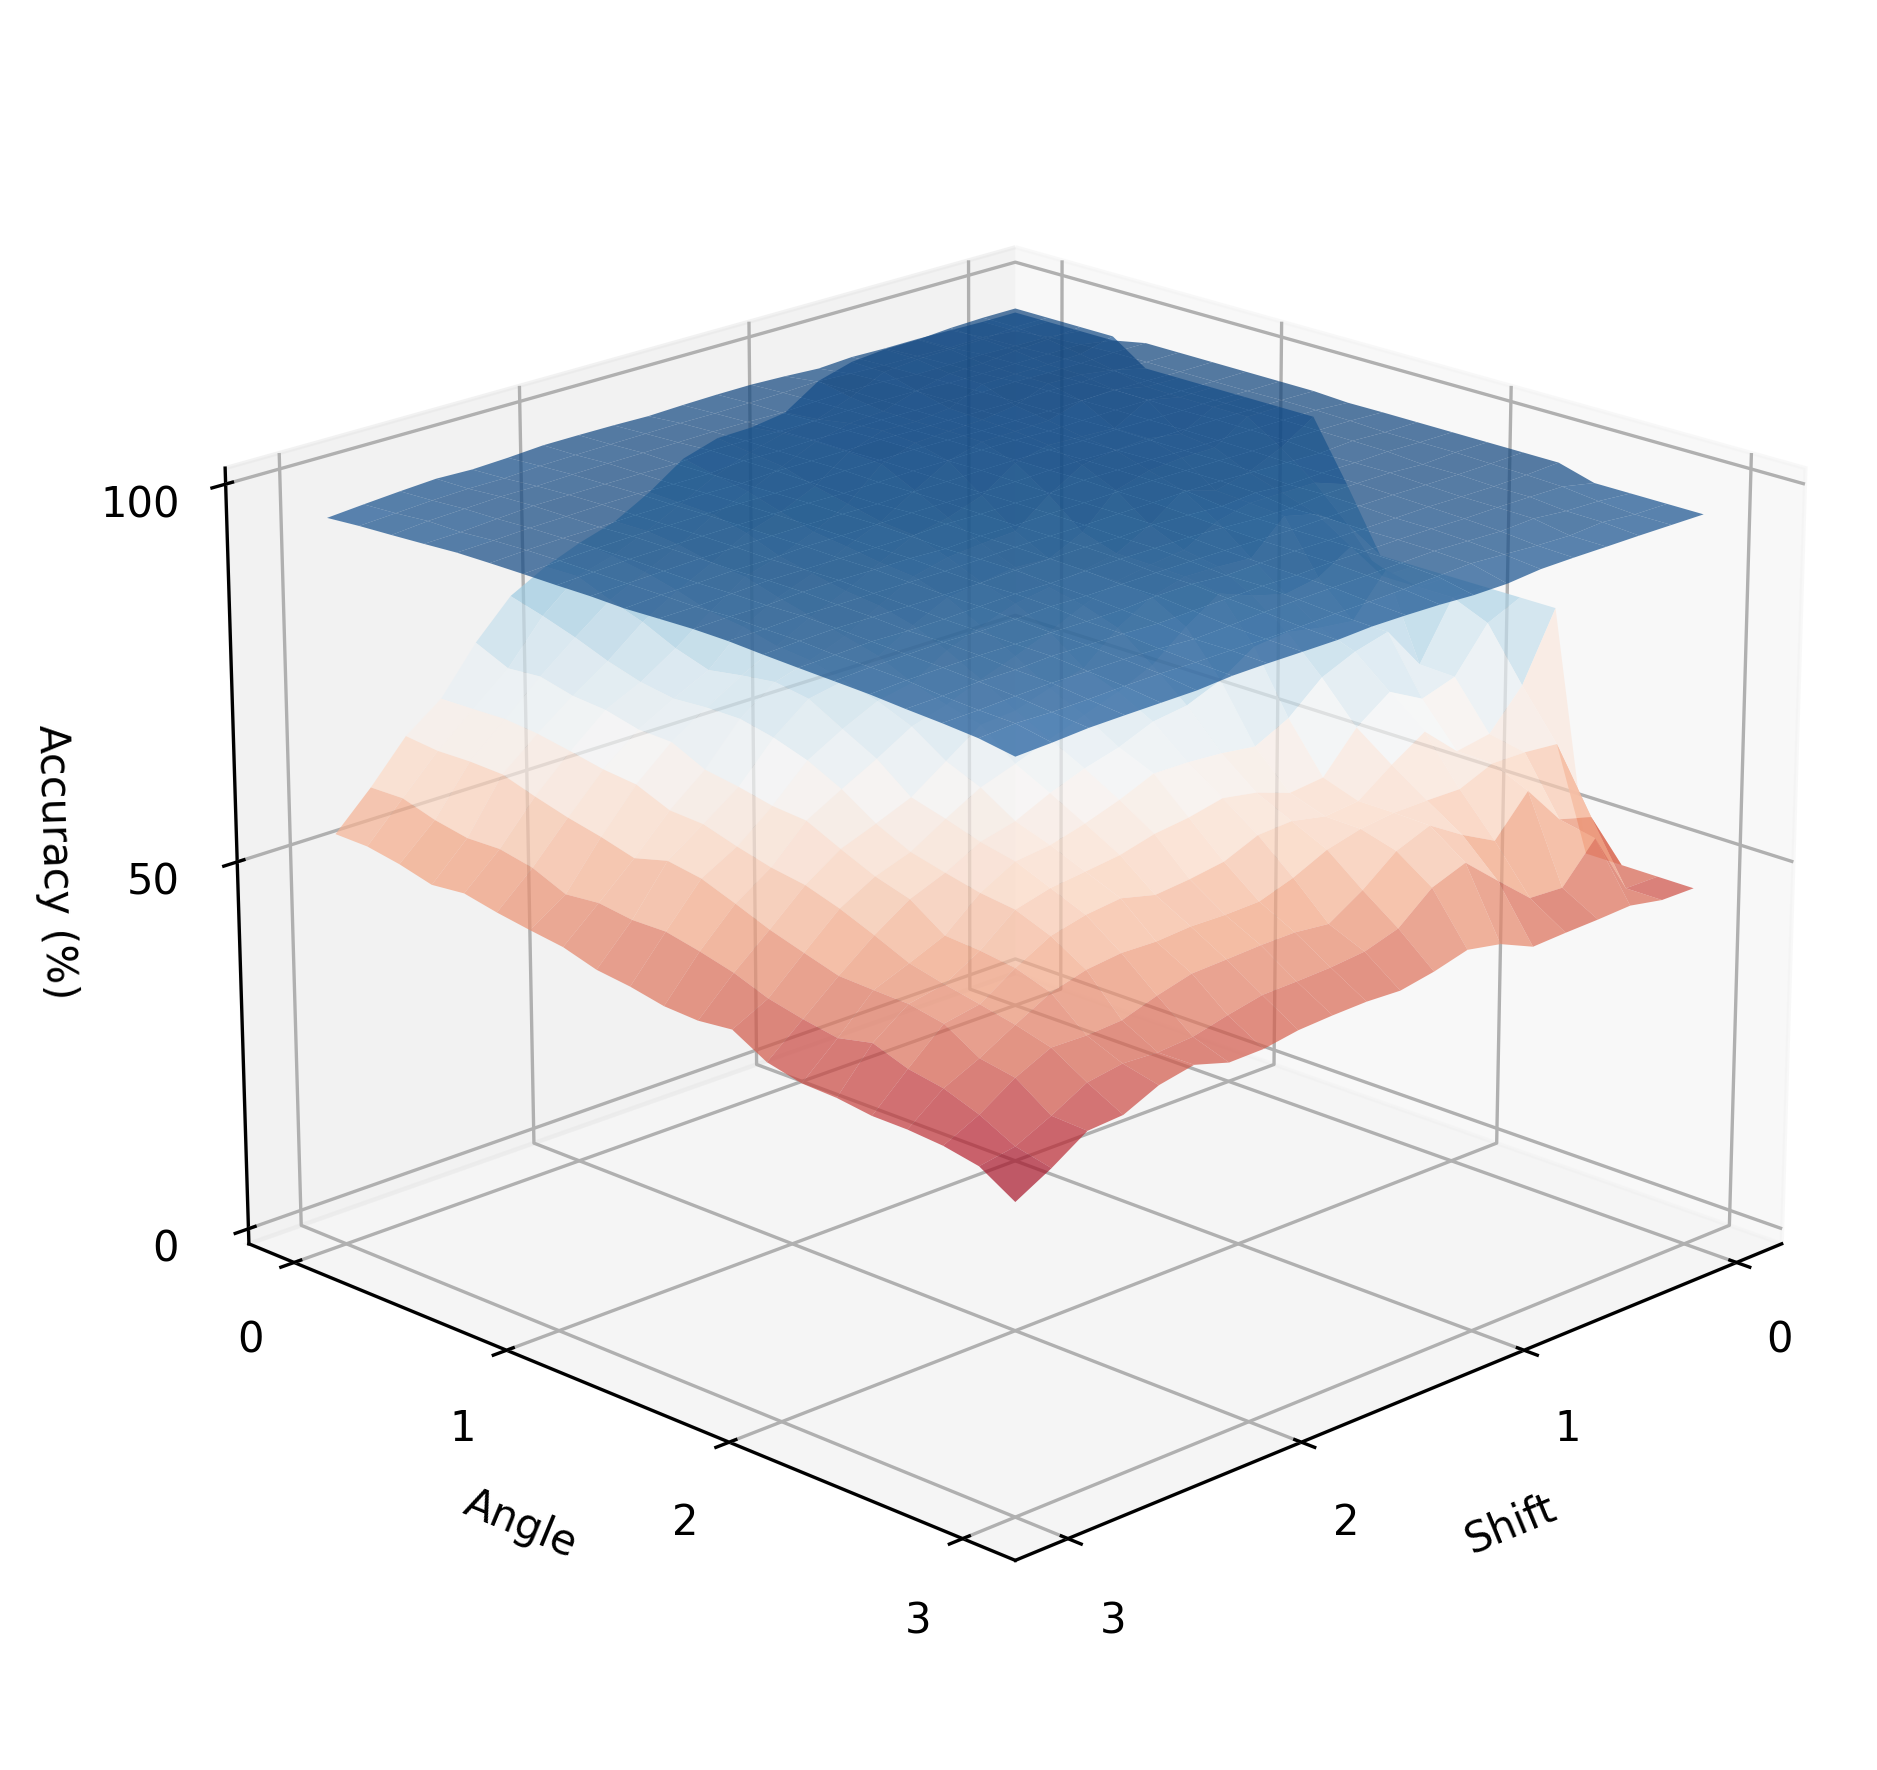

In [35]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
acc_grid_net = np.loadtxt('./Training Results/acc_grid_net.txt')
acc_grid_net_sam = np.loadtxt('./Training Results/acc_grid_net_sam.txt')
sweep_angle = np.linspace(0,3.0,21)
sweep_shift = np.linspace(0,3.0,21)
Angle, Shift = np.meshgrid(sweep_angle, sweep_shift)

fig = plt.figure(figsize=(6,6),dpi=300)
ax = fig.add_subplot(111, projection='3d')

color0 = 'RdBu'
color1 = 'twilight'
color2 = 'BuPu'
color3 = 'Greys_r'
color4 = 'hot'
color5 = 'GnPu'

# Net_test surface
surf1 = ax.plot_surface(Shift, Angle, acc_grid_net, cmap=color0, alpha=0.7, edgecolor='none',vmin=35,vmax=100)

# Net_test_sam surface
surf2 = ax.plot_surface(Shift, Angle, acc_grid_net_sam, cmap=color0, alpha=0.7, edgecolor='none',vmin=35,vmax=100)

ax.view_init(elev=20, azim=45)  

# Labels
ax.set_xlabel('Shift')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Angle')
ax.set_yticks([0,1,2,3])
ax.set_zlabel('Accuracy (%)')
ax.set_zticks([0,50,100])
ax.set_zlim(0, 100)

legend_elements = [
    Line2D([0], [0], color='blue', lw=4, label='net_test (viridis)'),
    Line2D([0], [0], color='red', lw=4, label='net_test_sam (plasma)')
]
# ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()
